In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
lb_h = 0.*np.ones((4,))
ub_h = 3.*np.ones((4,))

lb_dh = 0.*np.ones((2,))
ub_dh = 1.*np.ones((2,))

h = Parameter("h", 4, lb=lb_h, ub=ub_h)
dh = Parameter("dh", 2, lb=lb_dh, ub=ub_dh)
n = Parameter("n", 1, lb=1.99, ub=2.01)
epsilon = Parameter("epsilon", 1, lb=0.05, ub=.051)
parameters = [h, dh, n, epsilon]

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [12]:
# Define model
name = "V1Circuit"
model = Model(name, parameters)

In [13]:
from epi.example_eps import euler_sim, euler_sim_traj
import tensorflow as tf

X_INIT = tf.constant(np.random.normal(1.0, 0.01, (1, 4, 1)).astype(np.float32))


def V1_sim(h, dh, n, epsilon):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]
    n = n[:, :, None]
    epsilon = epsilon[:, :, None]
    
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    npzfile = np.load("data/V1_Zs.npz")
    _W = npzfile["Z_allen_square"][None, :, :]
    _W[:, :, 1:] = -_W[:, :, 1:]
    W = tf.constant(_W, dtype=tf.float32)

    def f(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = epsilon*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    r_t = euler_sim_traj(f, x_init, dt, T)
    return r_t

# Define eps
diff_prod_mean = -0.5
diff_sum_mean = 0.
def SV_flip(h, dh, n, epsilon):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]
    n = n[:, :, None]
    epsilon = epsilon[:, :, None]
    
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones_like(h, dtype=tf.float32)
    x_init = _x_shape*X_INIT

    npzfile = np.load("data/V1_Zs.npz")
    _W = npzfile["Z_allen_square"][None, :, :]
    _W[:, :, 1:] = -_W[:, :, 1:]
    W = tf.constant(_W, dtype=tf.float32)

    def f1(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = epsilon*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + noise) ** n)) / tau

    def f2(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = epsilon*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    ss1 = euler_sim(f1, x_init, dt, T)
    ss2 = euler_sim(f2, x_init, dt, T)
    
    diff1 = ss1[:,2]-ss1[:,3]
    diff2 = ss2[:,2]-ss2[:,3]
    diff_prod = diff1*diff2
    diff_sum = diff1+diff2
    T_x = tf.stack((diff_prod, 
                    diff_sum, 
                    (diff_prod - diff_prod_mean) ** 2, 
                    (diff_sum-diff_sum_mean) ** 2), axis=1)

    return T_x



model.set_eps(SV_flip)

In [14]:
D = sum([param.D for param in model.parameters])
lb = np.concatenate([param.lb for param in model.parameters])
ub = np.concatenate([param.ub for param in model.parameters])
print(D, lb)

8 [0.   0.   0.   0.   0.   0.   1.99 0.05]


In [15]:
M = 1000
num_keep = 100

mean = [-0.25, 0.]
std = [0.05, 0.05]

def accept_inds(T_x, mean ,std):
    return np.logical_and(np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0]),
                          np.logical_and(mean[1]-2*std[1] < T_x[:,1], T_x[:,1] < mean[1]+2*std[1]))

num_found = 0
z = None
T_x = None
x = []
while (num_found < num_keep):
    _z = np.zeros((M, D))
    for j in range(D):
        _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, mean, std)
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')
    x.append(num_found)

num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]



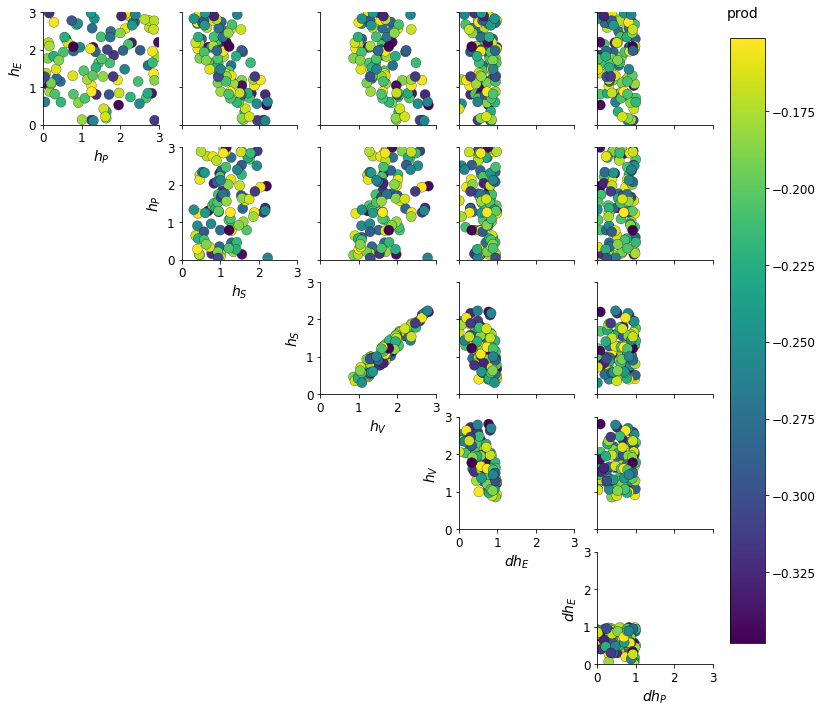

In [16]:
num_plot = 100
fontsize = 14
z_labels = [r'$h_E$', r'$h_P$', r'$h_S$', r'$h_V$', r'$dh_E$', r'$dh_P$', 'n', r'$\epsilon$']
fig = pairplot(z[:num_plot], np.arange(6), z_labels,
               fontsize=fontsize,
               xlims=[0, 3], ylims=[0, 3],
               c = T_x[:,0],
               c_label='prod')

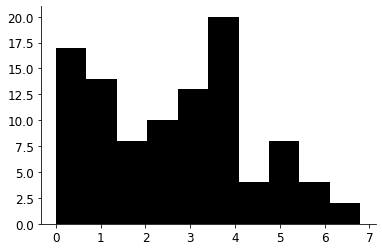

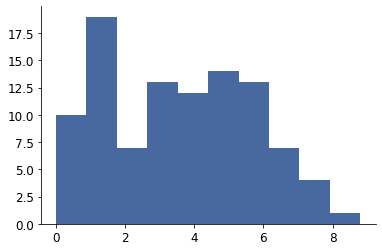

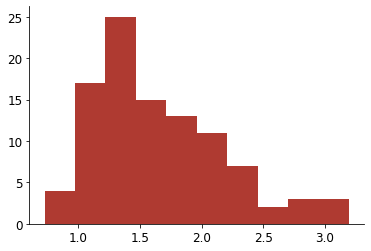

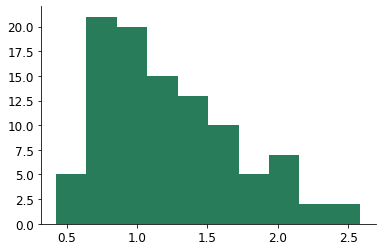

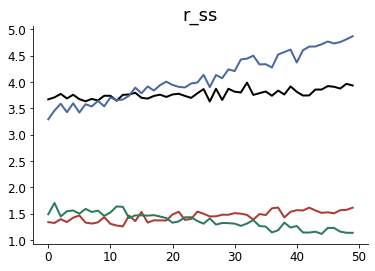

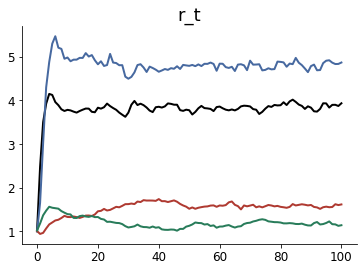

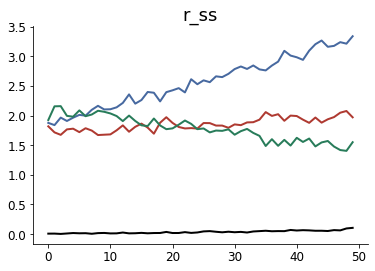

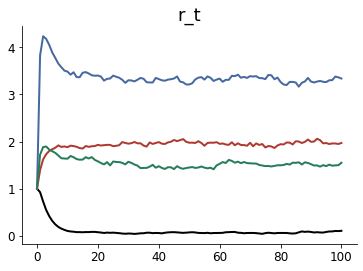

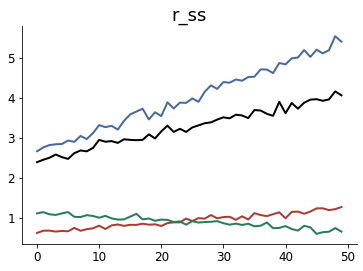

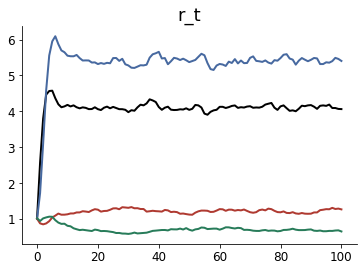

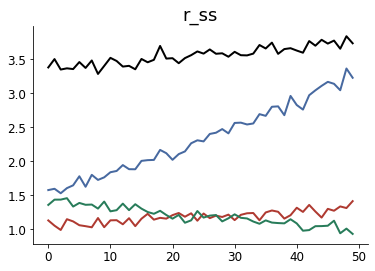

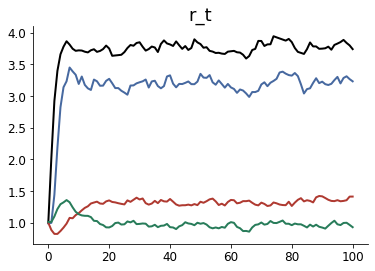

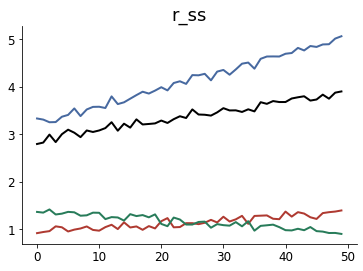

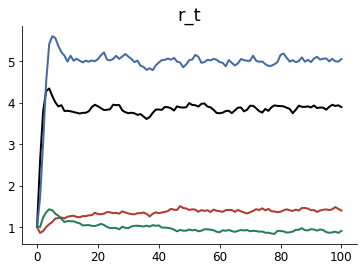

In [17]:
h = z[:,:4]
dh = z[:,4:6]
n = z[:,6:7]
epsilon = z[:,7:]

M = 50
T_xs = []
for i in range(M):
    alpha = float(i)/M
    T_xs.append(V1_sim(h, alpha*dh, n, epsilon)) 
T_xs = np.array(T_xs)


for i in range(4):
    plt.figure()
    plt.hist(T_xs[-1,:,i,-1], color=colors[i])
    plt.show()


num_plot = 0
i = 0
while num_plot < 5:
    if True:
        plt.figure()
        plt.plot(T_xs[:,i,0,-1], c=black)
        plt.plot(T_xs[:,i,1,-1], c=blue)
        plt.plot(T_xs[:,i,2,-1], c=red)
        plt.plot(T_xs[:,i,3,-1], c=green)
        plt.title('r_ss')
        plt.show()
        plt.figure()
        plt.plot(T_xs[-1,i,0,:], c=black)
        plt.plot(T_xs[-1,i,1,:], c=blue)
        plt.plot(T_xs[-1,i,2,:], c=red)
        plt.plot(T_xs[-1,i,3,:], c=green)
        plt.title('r_t')
        plt.show()
        num_plot += 1
    i += 1

In [18]:
epi_df = model.get_epi_df()
epi_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/epi/V1Circuit'